In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import f_oneway
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings
# Importar el módulo de configuración
from config.config import load_config, setup_project_paths, PROJECT_ROOT
warnings.filterwarnings('ignore')

# Import wordcloud for text visualization
try:
    from wordcloud import WordCloud
    wordcloud_available = True
    print("✅ WordCloud disponible")
except ImportError:
    wordcloud_available = False
    print("⚠️  WordCloud no disponible. Instalar con: pip install wordcloud")

print("✅ Librerías importadas correctamente")

✅ WordCloud disponible
✅ Librerías importadas correctamente


In [2]:
# Configurar directorios del proyecto y cargar configuración
setup_project_paths()  # Crea todos los directorios necesarios
config = load_config()

# Configuración del archivo CSV
CSV_FILE_PATH = PROJECT_ROOT / config.data.cleaned_data_path / "food/prompt_experiment_results_20251115_152059.csv"  # Cambiar por tu archivo

In [3]:
def load_csv_data(file_path: str) -> pd.DataFrame:
    """
    Carga datos desde un archivo CSV
    
    El CSV debe contener al menos las siguientes columnas:
    - 'food_item': Elemento de comida analizado
    - 'template_name': Nombre de la plantilla usada
    - 'response': Respuesta con dimensiones separadas por '|'
    - 'success': Indicador booleano de respuesta exitosa
    
    Args:
        file_path: Ruta al archivo CSV
    
    Returns:
        DataFrame con los datos cargados
    """
    try:
        df = pd.read_csv(file_path)
        
        # Validar columnas requeridas
        required_columns = ['food_item', 'template_name', 'sensations', 'human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            print(f"⚠️  Columnas faltantes: {missing_columns}")
            print(f"Columnas disponibles: {list(df.columns)}")
            return pd.DataFrame()
        
        print(f"✅ Archivo cargado exitosamente!")
        print(f"Shape: {df.shape}")
        print(f"Respuestas exitosas: {df['success'].sum()}/{len(df)}")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Archivo no encontrado: {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error cargando archivo: {e}")
        return pd.DataFrame()

print("📁 Configuración del archivo:")
print(f"Ruta: {CSV_FILE_PATH}")

# Cargar datos
df = load_csv_data(CSV_FILE_PATH)
# Usar solo los primeros 10 registros para vista previa
results_df = df

📁 Configuración del archivo:
Ruta: /Users/jorgesarmiento/workspace/personal/audio_reprompt/data/cleaned/food/prompt_experiment_results_20251115_152059.csv
✅ Archivo cargado exitosamente!
Shape: (600, 15)
Respuestas exitosas: 600/600


In [4]:
def prepare_data(dimensions_df: pd.DataFrame) -> Dict[str, List[str]]:
    """
    Prepara los datos para análisis ANOVA tokenizando términos por dimensión
    
    Args:
        dimensions_df: DataFrame con dimensiones separadas
    
    Returns:
        Diccionario con términos tokenizados por dimensión
    """
    if len(dimensions_df) == 0:
        return {}
    
    dimension_columns = ['sensations', 'human_responses', 'temperature', 
                        'texture', 'emotions', 'color', 'taste']
    
    anova_data = {}
    
    for dim in dimension_columns:
        if dim in dimensions_df.columns:
            # Extraer todos los términos de esta dimensión
            all_terms = []
            
            for response in dimensions_df[dim].dropna():
                # Separar por comas y limpiar
                terms = [term.strip().lower() for term in str(response).split(',')]
                # Filtrar términos vacíos
                terms = [term for term in terms if term and len(term) > 0]
                all_terms.extend(terms)
            
            anova_data[dim] = all_terms
    
    return anova_data

def analyze_term_frequencies(anova_data: Dict[str, List[str]]) -> Dict[str, Counter]:
    """
    Analiza las frecuencias de términos por dimensión
    
    Args:
        anova_data: Diccionario con términos por dimensión
    
    Returns:
        Diccionario con contadores de frecuencia por dimensión
    """
    frequency_analysis = {}
    
    for dimension, terms in anova_data.items():
        if len(terms) > 0:
            frequency_analysis[dimension] = Counter(terms)
    
    return frequency_analysis


In [5]:
def create_comparative_word_clouds(frequency_analysis: Dict[str, Counter], 
                                  top_n: int = 3) -> None:
    """
    Crea análisis comparativo de nubes de palabras mostrando las dimensiones 
    con mayor diversidad léxica
    
    Args:
        frequency_analysis: Diccionario con contadores de frecuencia por dimensión
        top_n: Número de dimensiones top a mostrar en detalle
    """
    if not wordcloud_available:
        print("⚠️  WordCloud no está disponible para análisis comparativo")
        return
        
    if not frequency_analysis:
        print("⚠️  No hay datos para análisis comparativo")
        return
    
    # Calcular métricas de diversidad por dimensión
    diversity_metrics = {}
    for dimension, counter in frequency_analysis.items():
        total_terms = sum(counter.values())
        unique_terms = len(counter)
        
        # Métricas de diversidad
        diversity_metrics[dimension] = {
            'total_terms': total_terms,
            'unique_terms': unique_terms,
            'diversity_ratio': unique_terms / total_terms if total_terms > 0 else 0,
            'entropy': -sum((freq/total_terms) * np.log2(freq/total_terms) 
                           for freq in counter.values()) if total_terms > 0 else 0,
            'max_frequency': max(counter.values()) if counter else 0,
            'counter': counter
        }
    
    # Ordenar por diversidad (ratio de términos únicos)
    sorted_dimensions = sorted(diversity_metrics.items(), 
                             key=lambda x: x[1]['diversity_ratio'], reverse=True)
    """
    print(f"📊 ANÁLISIS DE DIVERSIDAD LÉXICA")
    print("="*50)
    
    for i, (dimension, metrics) in enumerate(sorted_dimensions, 1):
        print(f"{i}. {dimension.upper()}:")
        print(f"   - Términos únicos: {metrics['unique_terms']}")
        print(f"   - Total términos: {metrics['total_terms']}")
        print(f"   - Ratio diversidad: {metrics['diversity_ratio']:.3f}")
        print(f"   - Entropía: {metrics['entropy']:.3f}")
        print()
    """
    # Mostrar nubes de palabras para las top N dimensiones más diversas
    if len(sorted_dimensions) > 0:
        top_dimensions = sorted_dimensions[:min(top_n, len(sorted_dimensions))]
        
        fig, axes = plt.subplots(1, len(top_dimensions), 
                                figsize=(6 * len(top_dimensions), 6))
        
        if len(top_dimensions) == 1:
            axes = [axes]
        
        fig.suptitle(f'Top {len(top_dimensions)} Dimensiones Más Diversas', 
                    fontsize=16, fontweight='bold')
        
        # Definir colores diferentes para cada dimensión
        color_schemes = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
        
        for i, (dimension, metrics) in enumerate(top_dimensions):
            counter = metrics['counter']
            
            if len(counter) > 0:
                # Configurar WordCloud con esquema de color único
                wordcloud_params = {
                    'width': 400,
                    'height': 400,
                    'background_color': 'white',
                    'max_words': 30,
                    'colormap': color_schemes[i % len(color_schemes)],
                    'relative_scaling': 0.6,
                    'min_font_size': 8,
                    'prefer_horizontal': 0.7
                }
                
                try:
                    wordcloud = WordCloud(**wordcloud_params).generate_from_frequencies(
                        dict(counter))
                    
                    axes[i].imshow(wordcloud, interpolation='bilinear')
                    axes[i].set_title(
                        f'{dimension.title()}\nDiversidad: {metrics["diversity_ratio"]:.3f}\n'
                        f'Entropía: {metrics["entropy"]:.2f}',
                        fontsize=12, fontweight='bold'
                    )
                    axes[i].axis('off')
                    
                except Exception as e:
                    axes[i].text(0.5, 0.5, f'Error\n{dimension}', 
                               ha='center', va='center', transform=axes[i].transAxes)
                    axes[i].set_title(dimension.title())
                    axes[i].axis('off')
            else:
                axes[i].text(0.5, 0.5, 'Sin datos', ha='center', va='center',
                           transform=axes[i].transAxes)
                axes[i].set_title(dimension.title())
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Análisis de términos únicos vs comunes
        print(f"\n🔍 ANÁLISIS DE TÉRMINOS ÚNICOS:")
        
        # Encontrar términos que aparecen en múltiples dimensiones
        all_terms = set()
        for counter in frequency_analysis.values():
            all_terms.update(counter.keys())
        
        # Contar en cuántas dimensiones aparece cada término
        term_dimension_count = Counter()
        for term in all_terms:
            count = sum(1 for counter in frequency_analysis.values() if term in counter)
            term_dimension_count[term] = count
        
        # Términos exclusivos (solo en una dimensión)
        exclusive_terms = [term for term, count in term_dimension_count.items() if count == 1]
        shared_terms = [term for term, count in term_dimension_count.items() if count > 1]
        
        print(f"   - Términos exclusivos: {len(exclusive_terms)}")
        print(f"   - Términos compartidos: {len(shared_terms)}")
        
        if shared_terms:
            most_shared = max(term_dimension_count.items(), key=lambda x: x[1])
            print(f"   - Término más compartido: '{most_shared[0]}' ({most_shared[1]} dimensiones)")

In [6]:
def create_text_frequency_visualizations(frequency_analysis: Dict[str, Counter], 
                                        top_terms: int = 10) -> None:
    """
    Crea visualizaciones alternativas de frecuencia de términos usando barras horizontales
    cuando WordCloud no está disponible
    
    Args:
        frequency_analysis: Diccionario con contadores de frecuencia por dimensión
        top_terms: Número de términos top a mostrar por dimensión
    """
    if not frequency_analysis:
        print("⚠️  No hay datos de frecuencia para visualizar")
        return
    
    dimensions = list(frequency_analysis.keys())
    n_dims = len(dimensions)
    
    if n_dims == 0:
        print("⚠️  No hay dimensiones para visualizar")
        return
    
    # Configurar subplots
    cols = 2
    rows = (n_dims + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    fig.suptitle('Frecuencia de Términos por Dimensión (Top 10)', 
                fontsize=16, fontweight='bold')
    
    # Manejar el caso de un solo subplot
    if n_dims == 1:
        axes = [axes] if rows * cols == 1 else [axes[0]]
    elif rows == 1:
        axes = [axes] if n_dims == 1 else axes
    else:
        axes = axes.flatten()
    
    # Paleta de colores
    colors = plt.cm.Set3(np.linspace(0, 1, n_dims))
    
    for i, (dimension, counter) in enumerate(frequency_analysis.items()):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        if len(counter) > 0:
            # Obtener top términos
            top_items = counter.most_common(top_terms)
            terms, frequencies = zip(*top_items) if top_items else ([], [])
            
            # Crear barras horizontales
            y_pos = np.arange(len(terms))
            bars = ax.barh(y_pos, frequencies, color=colors[i], alpha=0.7)
            
            # Configurar ejes
            ax.set_yticks(y_pos)
            ax.set_yticklabels(terms)
            ax.invert_yaxis()  # Términos con mayor frecuencia arriba
            ax.set_xlabel('Frecuencia')
            ax.set_title(f'{dimension.title()}\n({len(counter)} términos únicos)', 
                        fontsize=12, fontweight='bold')
            
            # Añadir valores en las barras
            for j, (bar, freq) in enumerate(zip(bars, frequencies)):
                width = bar.get_width()
                ax.text(width + max(frequencies) * 0.01, bar.get_y() + bar.get_height()/2,
                       f'{freq}', ha='left', va='center', fontweight='bold')
            
            # Grid para facilitar lectura
            ax.grid(axis='x', alpha=0.3)
            
        else:
            ax.text(0.5, 0.5, f'Sin datos para\n{dimension}', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=14)
            ax.set_title(dimension.title(), fontsize=12)
        
        # Remover spines innecesarios
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Ocultar subplots vacíos
    for i in range(n_dims, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Crear gráfico de barras comparativo por diversidad
    print("\n📊 Creando gráfico de diversidad léxica...")
    
    # Calcular métricas de diversidad
    diversity_data = []
    for dimension, counter in frequency_analysis.items():
        total_terms = sum(counter.values())
        unique_terms = len(counter)
        diversity_ratio = unique_terms / total_terms if total_terms > 0 else 0
        
        diversity_data.append({
            'dimension': dimension,
            'unique_terms': unique_terms,
            'total_terms': total_terms,
            'diversity_ratio': diversity_ratio
        })
    
    # Ordenar por ratio de diversidad
    diversity_data.sort(key=lambda x: x['diversity_ratio'], reverse=True)
    
    # Crear gráfico de diversidad
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Análisis de Diversidad Léxica por Dimensión', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Términos únicos vs totales
    dimensions_names = [d['dimension'] for d in diversity_data]
    unique_counts = [d['unique_terms'] for d in diversity_data]
    total_counts = [d['total_terms'] for d in diversity_data]
    
    x = np.arange(len(dimensions_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, unique_counts, width, label='Términos únicos', alpha=0.8)
    bars2 = ax1.bar(x + width/2, total_counts, width, label='Total términos', alpha=0.8)
    
    ax1.set_xlabel('Dimensiones')
    ax1.set_ylabel('Número de términos')
    ax1.set_title('Términos Únicos vs Total por Dimensión')
    ax1.set_xticks(x)
    ax1.set_xticklabels([d.title() for d in dimensions_names], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
    
    # Gráfico 2: Ratio de diversidad
    diversity_ratios = [d['diversity_ratio'] for d in diversity_data]
    bars3 = ax2.bar(dimensions_names, diversity_ratios, 
                    color=plt.cm.viridis(np.linspace(0, 1, len(dimensions_names))), 
                    alpha=0.8)
    
    ax2.set_xlabel('Dimensiones')
    ax2.set_ylabel('Ratio de Diversidad')
    ax2.set_title('Ratio de Diversidad Léxica\n(Términos únicos / Total términos)')
    ax2.set_xticklabels(dimensions_names, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for bar, ratio in zip(bars3, diversity_ratios):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Resumen textual
    print(f"\n📈 RESUMEN DE VISUALIZACIONES:")
    print(f"   - Dimensiones analizadas: {n_dims}")
    print(f"   - Terms por dimensión (top {top_terms} mostrados)")
    
    most_diverse = max(diversity_data, key=lambda x: x['diversity_ratio'])
    least_diverse = min(diversity_data, key=lambda x: x['diversity_ratio'])
    
    print(f"   - Más diversa: {most_diverse['dimension']} ({most_diverse['diversity_ratio']:.3f})")
    print(f"   - Menos diversa: {least_diverse['dimension']} ({least_diverse['diversity_ratio']:.3f})")

# Ejecutar visualizaciones alternativas (siempre disponibles)
if 'frequency_analysis' in locals() and frequency_analysis:
    print("📊 Creando visualizaciones de frecuencia de términos...")
    create_text_frequency_visualizations(frequency_analysis, top_terms=10)
else:
    print("⚠️  No hay análisis de frecuencias para las visualizaciones")

⚠️  No hay análisis de frecuencias para las visualizaciones


📊 Plantillas encontradas: ['sensations_emotions_mapping_no_bias'
 'sensations_emotions_mapping_with_acceptance_criteria']
🔄 Preparando datos para análisis ANOVA...
✅ Datos preparados!
Dimensiones encontradas: ['sensations', 'human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']

📊 Estadísticas por dimensión:
  sensations:
    - Total términos: 902
    - Términos únicos: 62
    - Diversidad: 0.07
    - Top 3 términos: [('savory', 107), ('creamy', 88), ('umami', 87)]

  human_responses:
    - Total términos: 897
    - Términos únicos: 67
    - Diversidad: 0.07
    - Top 3 términos: [('satisfaction', 210), ('warmth', 130), ('comfort', 93)]

  temperature:
    - Total términos: 299
    - Términos únicos: 4
    - Diversidad: 0.01
    - Top 3 términos: [('warm', 161), ('hot', 69), ('cold', 54)]

  texture:
    - Total términos: 897
    - Términos únicos: 50
    - Diversidad: 0.06
    - Top 3 términos: [('smooth', 138), ('creamy', 88), ('soft', 84)]

  emotions:
    - Tota

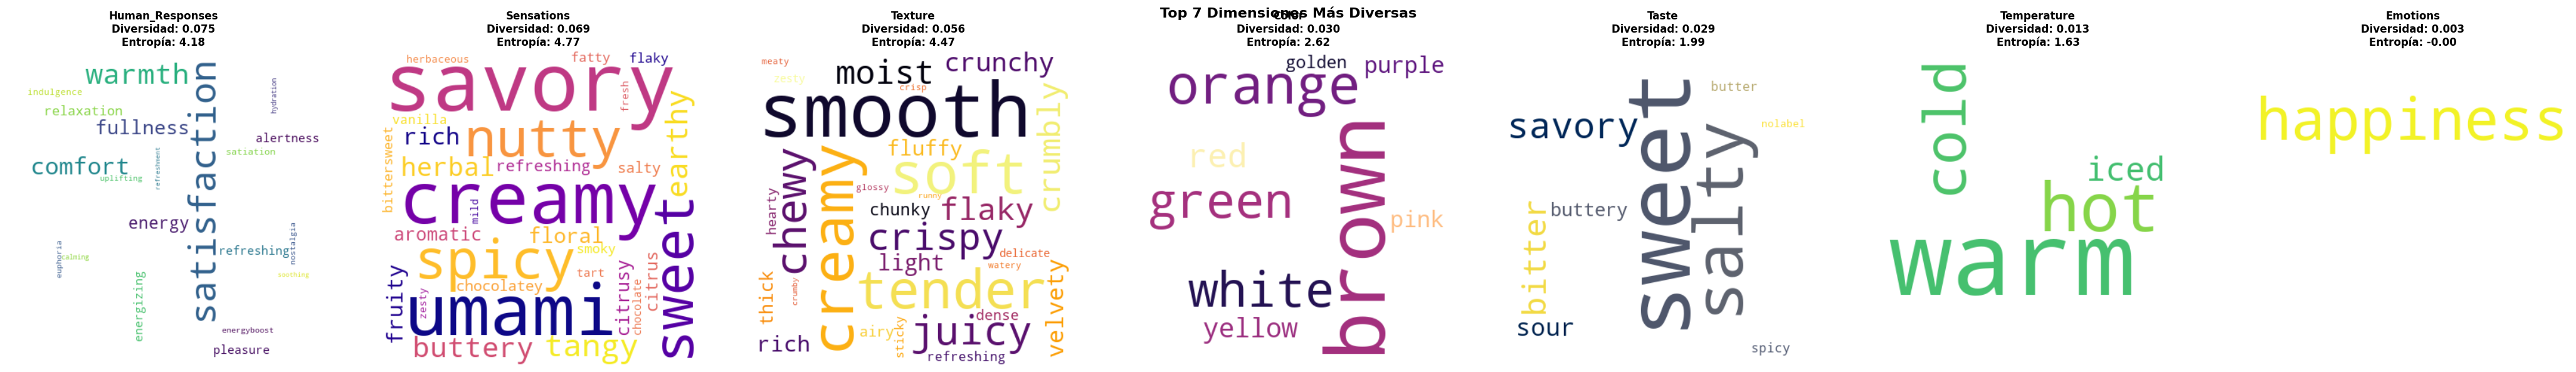


🔍 ANÁLISIS DE TÉRMINOS ÚNICOS:
   - Términos exclusivos: 154
   - Términos compartidos: 22
   - Término más compartido: 'warm' (3 dimensiones)


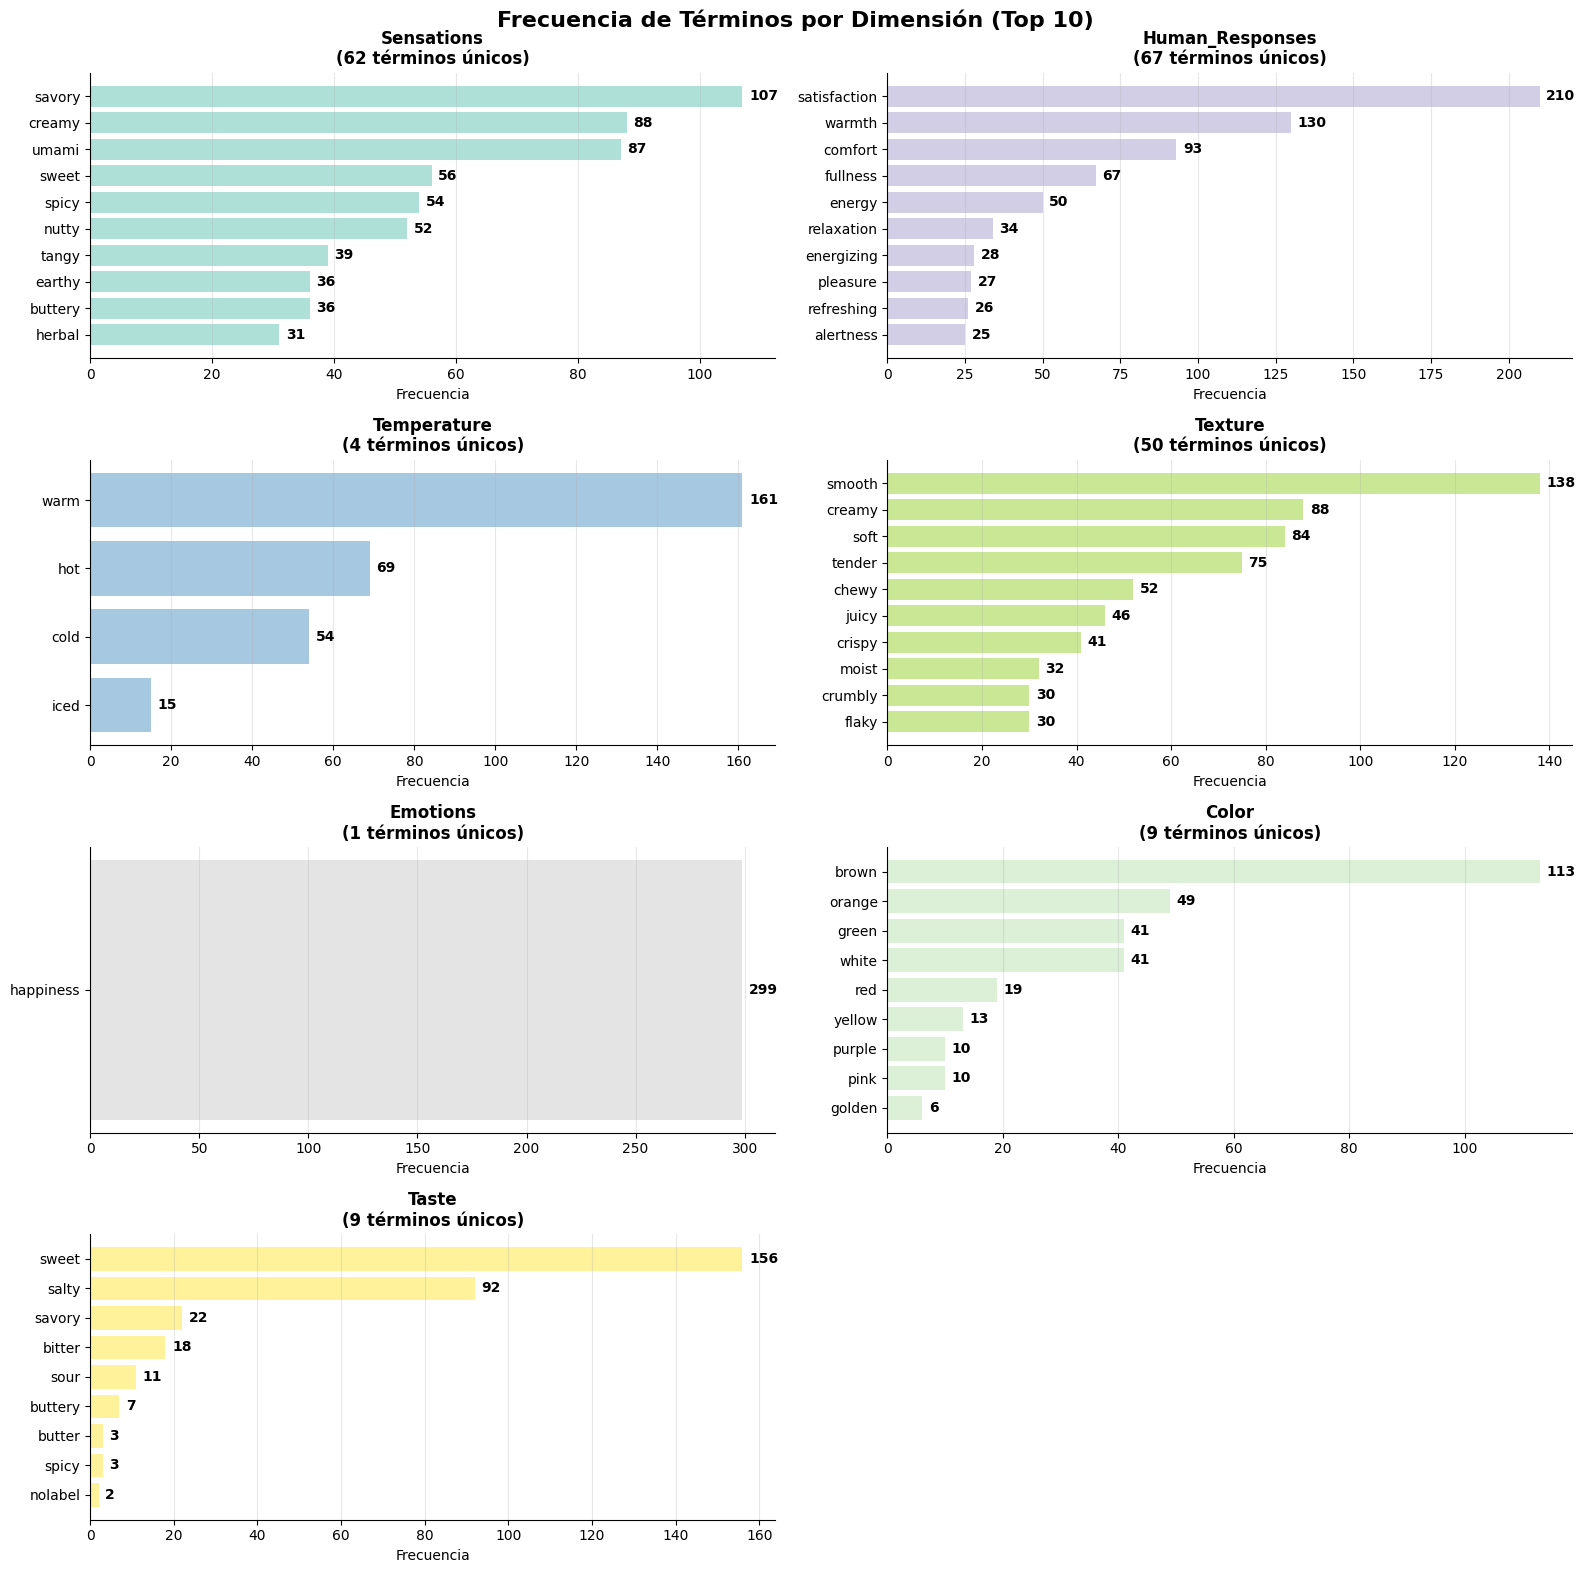


📊 Creando gráfico de diversidad léxica...


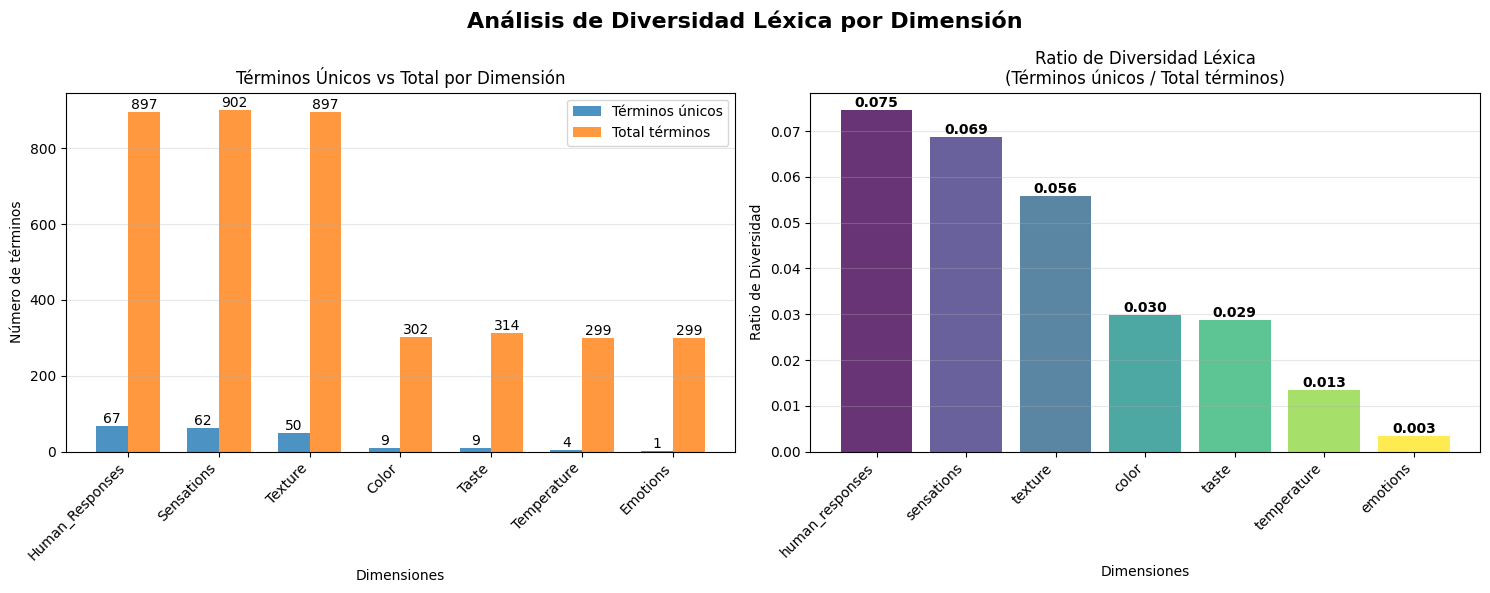


📈 RESUMEN DE VISUALIZACIONES:
   - Dimensiones analizadas: 7
   - Terms por dimensión (top 10 mostrados)
   - Más diversa: human_responses (0.075)
   - Menos diversa: emotions (0.003)


In [7]:

# Preparar datos para análisis de frecuencia de términoss
# Separar results_df en dos data frames basados en la columna template_name
template_names = results_df['template_name'].unique()
print(f"📊 Plantillas encontradas: {template_names}")
template_bias_df = results_df[results_df['template_name'] == template_names[0]]
template_bias_ac = results_df[results_df['template_name'] == template_names[1]]


if 'template_bias_df' in locals() and len(template_bias_df) > 0:
    print("🔄 Preparando datos para análisis ANOVA...")
    anova_data = prepare_data(template_bias_df)
    frequency_analysis = analyze_term_frequencies(anova_data)
    
    print("✅ Datos preparados!")
    print(f"Dimensiones encontradas: {list(anova_data.keys())}")
    
    # Mostrar estadísticas básicas por dimensión
    print(f"\n📊 Estadísticas por dimensión:")
    for dim, terms in anova_data.items():
        unique_terms = len(set(terms))
        total_terms = len(terms)
        print(f"  {dim}:")
        print(f"    - Total términos: {total_terms}")
        print(f"    - Términos únicos: {unique_terms}")
        print(f"    - Diversidad: {unique_terms/total_terms:.2f}")
        
        # Mostrar los 3 términos más frecuentes
        if dim in frequency_analysis and len(frequency_analysis[dim]) > 0:
            top_terms = frequency_analysis[dim].most_common(3)
            print(f"    - Top 3 términos: {top_terms}")
        print()

    create_comparative_word_clouds(frequency_analysis, top_n=7)
    create_text_frequency_visualizations(frequency_analysis, top_terms=10)
else:
    print("⚠️  No hay datos para preparar el análisis ANOVA")

🔄 Preparando datos para análisis ANOVA...
✅ Datos preparados!
Dimensiones encontradas: ['sensations', 'human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']

📊 Estadísticas por dimensión:
  sensations:
    - Total términos: 890
    - Términos únicos: 73
    - Diversidad: 0.08
    - Top 3 términos: [('savory', 107), ('umami', 78), ('creamy', 77)]

  human_responses:
    - Total términos: 880
    - Términos únicos: 89
    - Diversidad: 0.10
    - Top 3 términos: [('satisfaction', 193), ('warmth', 130), ('comfort', 78)]

  temperature:
    - Total términos: 296
    - Términos únicos: 6
    - Diversidad: 0.02
    - Top 3 términos: [('warm', 161), ('hot', 62), ('cold', 58)]

  texture:
    - Total términos: 882
    - Términos únicos: 56
    - Diversidad: 0.06
    - Top 3 términos: [('smooth', 127), ('creamy', 80), ('soft', 71)]

  emotions:
    - Total términos: 296
    - Términos únicos: 3
    - Diversidad: 0.01
    - Top 3 términos: [('happiness', 292), ('nolabel', 3),

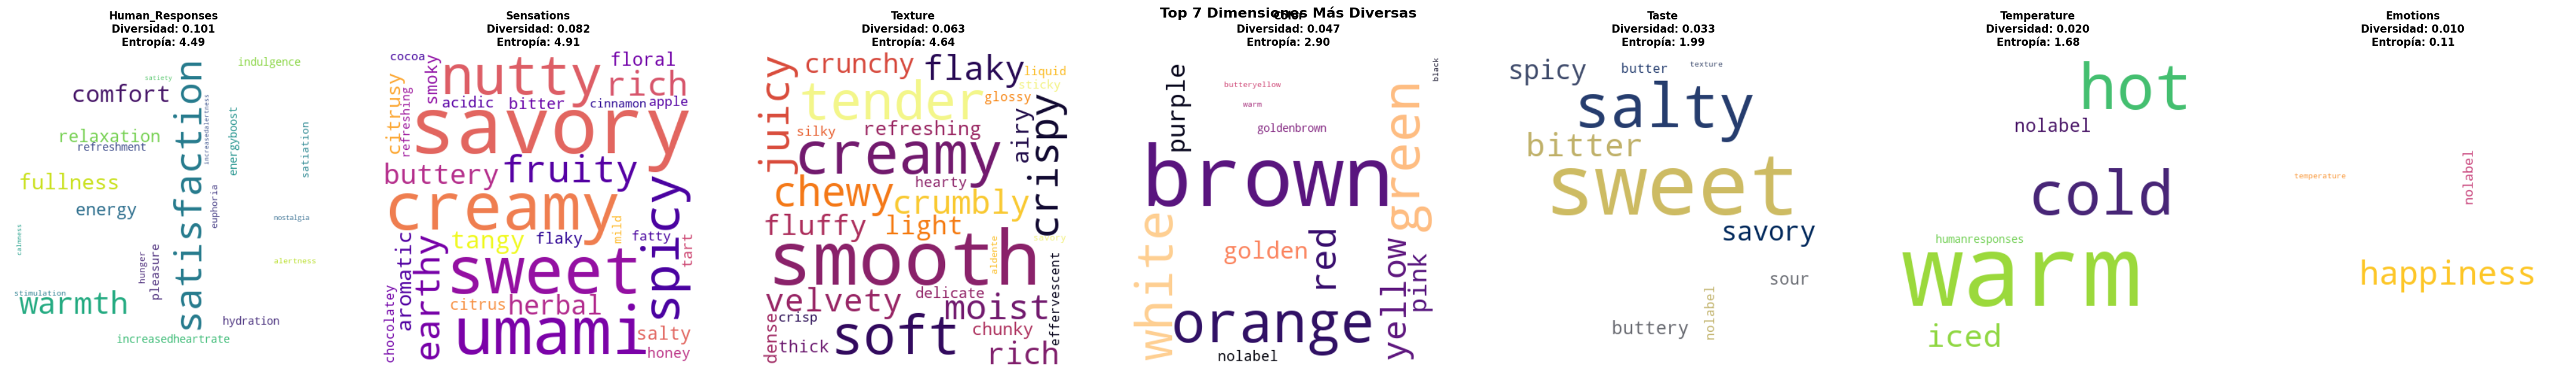


🔍 ANÁLISIS DE TÉRMINOS ÚNICOS:
   - Términos exclusivos: 171
   - Términos compartidos: 35
   - Término más compartido: 'nolabel' (7 dimensiones)


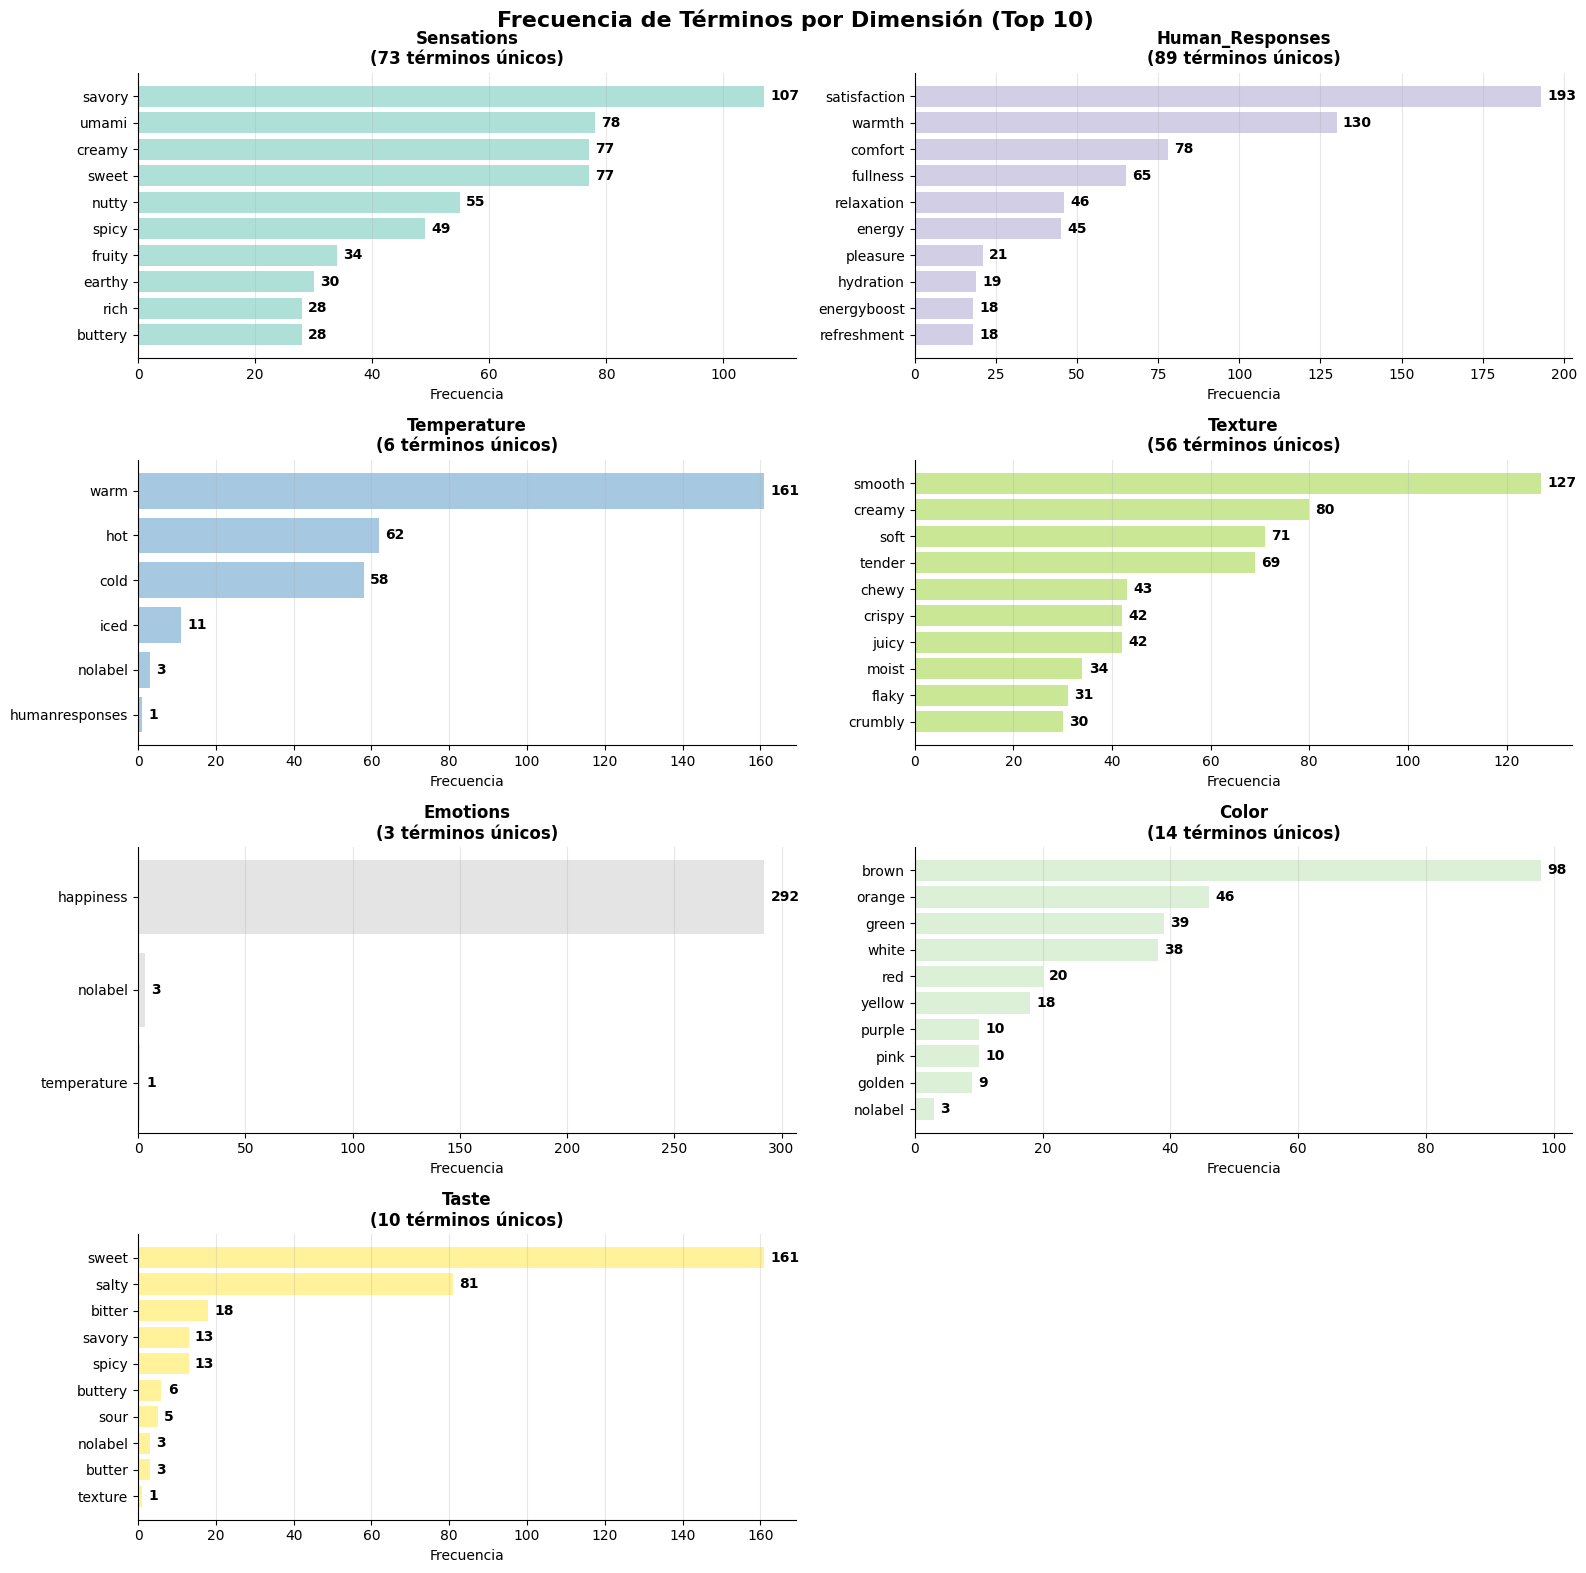


📊 Creando gráfico de diversidad léxica...


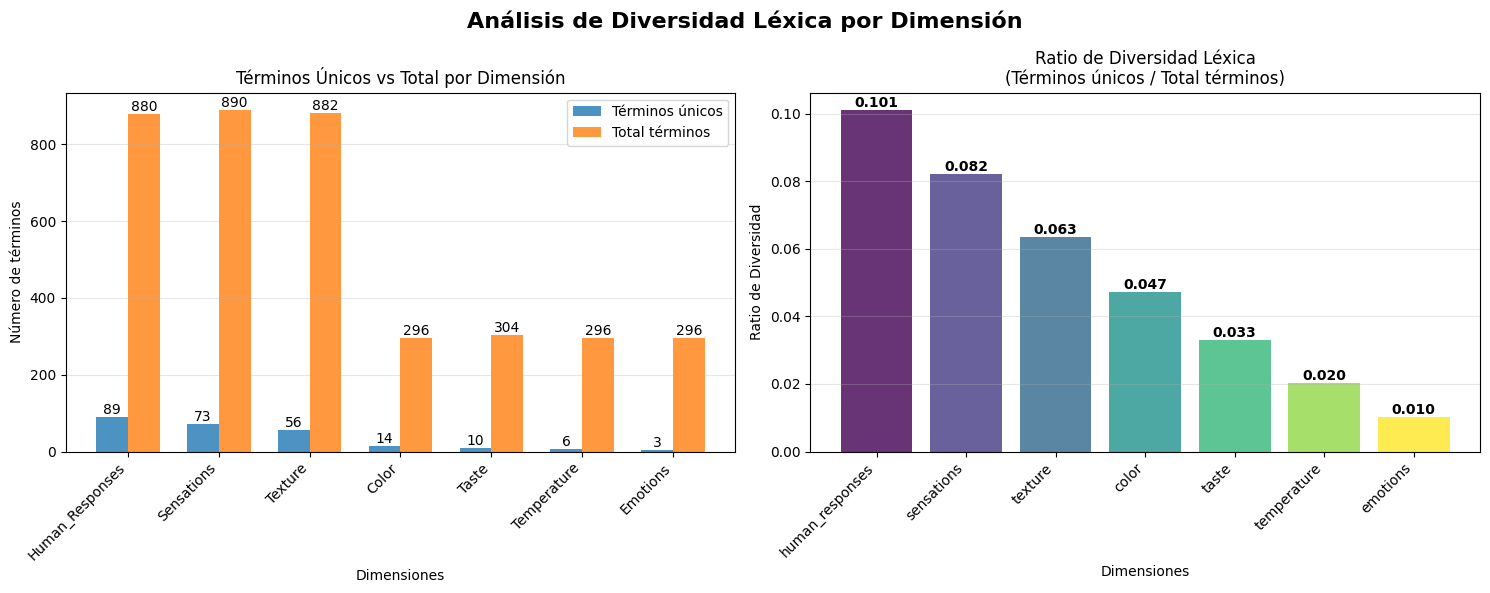


📈 RESUMEN DE VISUALIZACIONES:
   - Dimensiones analizadas: 7
   - Terms por dimensión (top 10 mostrados)
   - Más diversa: human_responses (0.101)
   - Menos diversa: emotions (0.010)


In [8]:
if 'template_bias_ac' in locals() and len(template_bias_ac) > 0:
    print("🔄 Preparando datos para análisis ANOVA...")
    anova_data = prepare_data(template_bias_ac)
    frequency_analysis = analyze_term_frequencies(anova_data)
    
    print("✅ Datos preparados!")
    print(f"Dimensiones encontradas: {list(anova_data.keys())}")
    
    # Mostrar estadísticas básicas por dimensión
    print(f"\n📊 Estadísticas por dimensión:")
    for dim, terms in anova_data.items():
        unique_terms = len(set(terms))
        total_terms = len(terms)
        print(f"  {dim}:")
        print(f"    - Total términos: {total_terms}")
        print(f"    - Términos únicos: {unique_terms}")
        print(f"    - Diversidad: {unique_terms/total_terms:.2f}")
        
        # Mostrar los 3 términos más frecuentes
        if dim in frequency_analysis and len(frequency_analysis[dim]) > 0:
            top_terms = frequency_analysis[dim].most_common(3)
            print(f"    - Top 3 términos: {top_terms}")
        print()

    create_comparative_word_clouds(frequency_analysis, top_n=7)
    create_text_frequency_visualizations(frequency_analysis, top_terms=10)
else:
    print("⚠️  No hay datos para preparar el análisis ANOVA")